In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime

# Para modelado
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Dataset, Reader, SVD
from surprise.model_selection import cross_validate

# Configuración
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("Librerías importadas exitosamente")
print(f"Fecha de ejecución: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✓ Librerías importadas exitosamente
Fecha de ejecución: 2025-10-27 14:23:19


In [ ]:
file_path = 'shopping_behavior_updated.csv'

try:
    df = pd.read_csv(file_path)
    print(f"Datos cargados exitosamente")
    print(f"  - Registros: {df.shape[0]:,}")
    print(f"  - Variables: {df.shape[1]}")
    print(f"\nPrimeras filas del dataset:")
    display(df.head())
except FileNotFoundError:
    print(f"Error: No se encontró el archivo '{file_path}'")
    print("Por favor, asegúrate de que el archivo esté en la misma carpeta que este notebook")

# %%
# Información general del dataset
print("Información del Dataset:")
print(df.info())

✓ Datos cargados exitosamente
  - Registros: 3,900
  - Variables: 18

📊 Primeras filas del dataset:


,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Express,Yes,Yes,14,Venmo,Fortnightly
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Express,Yes,Yes,2,Cash,Fortnightly
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Free Shipping,Yes,Yes,23,Credit Card,Weekly
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,Next Day Air,Yes,Yes,49,PayPal,Weekly
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Free Shipping,Yes,Yes,31,PayPal,Annually


📋 Información del Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Customer ID             3900 non-null   int64  
 1   Age                     3900 non-null   int64  
 2   Gender                  3900 non-null   object 
 3   Item Purchased          3900 non-null   object 
 4   Category                3900 non-null   object 
 5   Purchase Amount (USD)   3900 non-null   int64  
 6   Location                3900 non-null   object 
 7   Size                    3900 non-null   object 
 8   Color                   3900 non-null   object 
 9   Season                  3900 non-null   object 
 10  Review Rating           3900 non-null   float64
 11  Subscription Status     3900 non-null   object 
 12  Shipping Type           3900 non-null   object 
 13  Discount Applied        3900 non-null   object 
 14  Promo Code Us

In [ ]:
print("Análisis de Valores Nulos:")
missing_values = df.isnull().sum()
if missing_values.sum() > 0:
    print(missing_values[missing_values > 0])
else:
    print("No se encontraron valores nulos")

# Duplicados
duplicates = df.duplicated().sum()
print(f"\nRegistros duplicados: {duplicates}")
if duplicates > 0:
    df = df.drop_duplicates()
    print(f"  Duplicados eliminados. Registros restantes: {len(df)}")

# %%
# Estadísticas descriptivas
print("Estadísticas Descriptivas de Variables Numéricas:")
display(df.describe())

# %%
# Limpieza y conversión de tipos de datos
if 'Purchase Amount (USD)' in df.columns:
    df['Purchase Amount (USD)'] = pd.to_numeric(df['Purchase Amount (USD)'], errors='coerce')

if 'Review Rating' in df.columns:
    df['Review Rating'] = pd.to_numeric(df['Review Rating'], errors='coerce')

if 'Previous Purchases' in df.columns:
    df['Previous Purchases'] = pd.to_numeric(df['Previous Purchases'], errors='coerce')

# Crear variables adicionales
df['Customer_Segment'] = pd.cut(df['Age'], 
                                 bins=[0, 25, 40, 60, 100], 
                                 labels=['Joven', 'Adulto', 'Maduro', 'Senior'])

# Valor total de compras por cliente
customer_value = df.groupby('Customer ID')['Purchase Amount (USD)'].sum().reset_index()
customer_value.columns = ['Customer ID', 'Total_Purchase_Value']
df = df.merge(customer_value, on='Customer ID', how='left')

print("Datos limpiados y preparados exitosamente")

🔍 Análisis de Valores Nulos:
✓ No se encontraron valores nulos

🔄 Registros duplicados: 0
📈 Estadísticas Descriptivas de Variables Numéricas:


,Customer ID,Age,Purchase Amount (USD),Review Rating,Previous Purchases
count,3900.000000,3900.000000,3900.000000,3900.000000,3900.000000
mean,1950.500000,44.068462,59.764359,3.749949,25.351538
std,1125.977353,15.207589,23.685392,0.716223,14.447125
min,1.000000,18.000000,20.000000,2.500000,1.000000
25%,975.750000,31.000000,39.000000,3.100000,13.000000
50%,1950.500000,44.000000,60.000000,3.700000,25.000000
75%,2925.250000,57.000000,81.000000,4.400000,38.000000
max,3900.000000,70.000000,100.000000,5.000000,50.000000


✓ Datos limpiados y preparados exitosamente


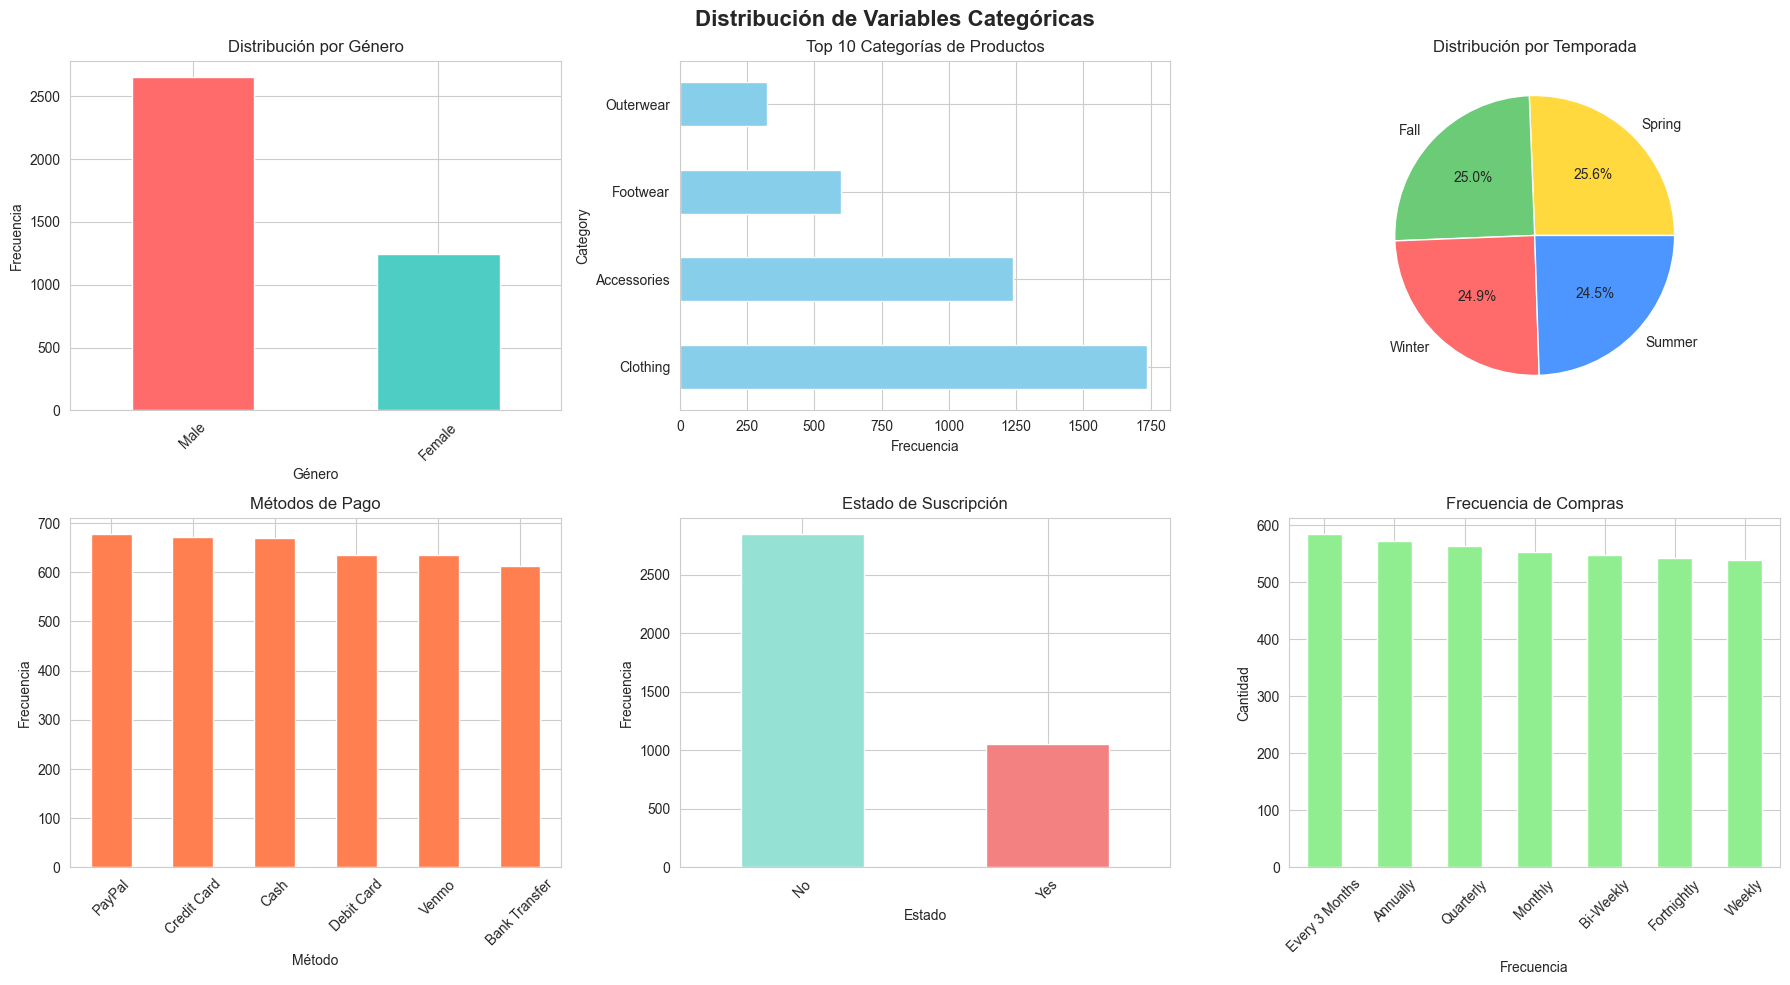

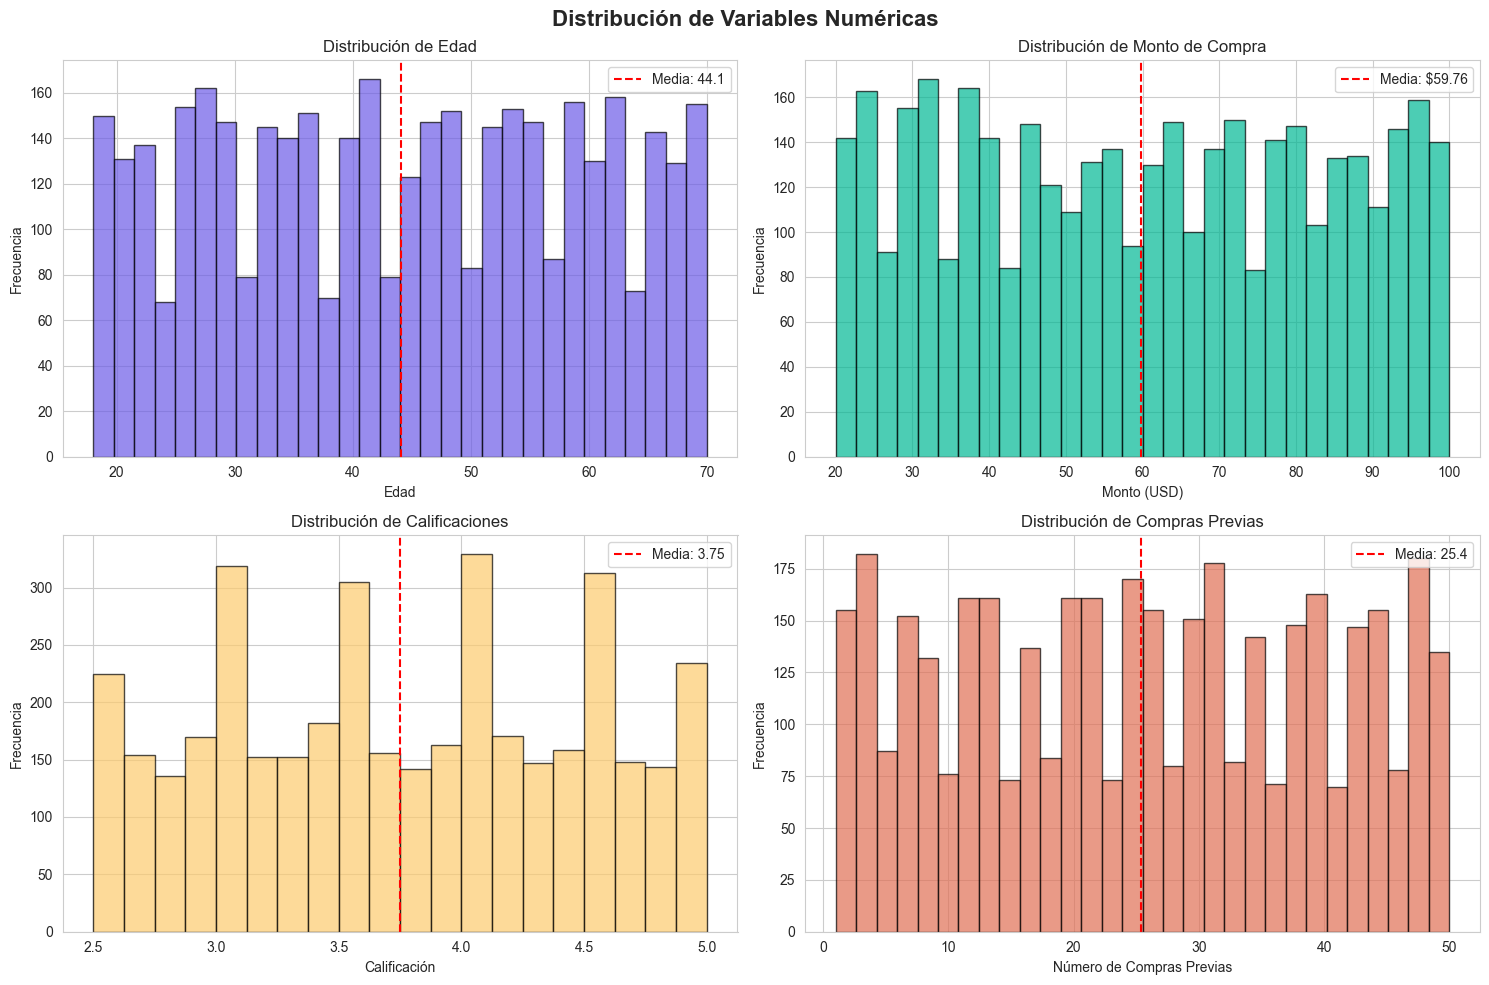

🔗 Matriz de Correlación:


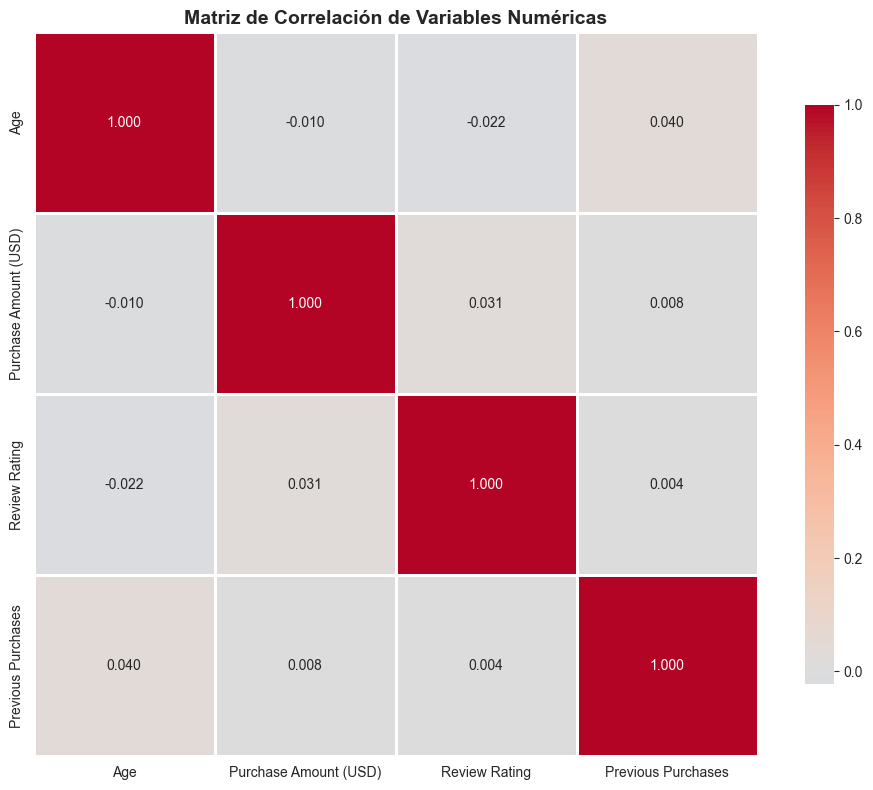

📊 Análisis por Segmento de Edad:


Purchase Amount (USD)              Review Rating  \
                                  mean    sum count          mean   
Customer_Segment                                                    
Joven                            60.65  34630   571          3.82   
Adulto                           59.69  65842  1103          3.75   
Maduro                           59.51  89445  1503          3.72   
Senior                           59.70  43164   723          3.76   

                 Previous Purchases  
                               mean  
Customer_Segment                     
Joven                         24.63  
Adulto                        25.04  
Maduro                        25.51  
Senior                        26.06

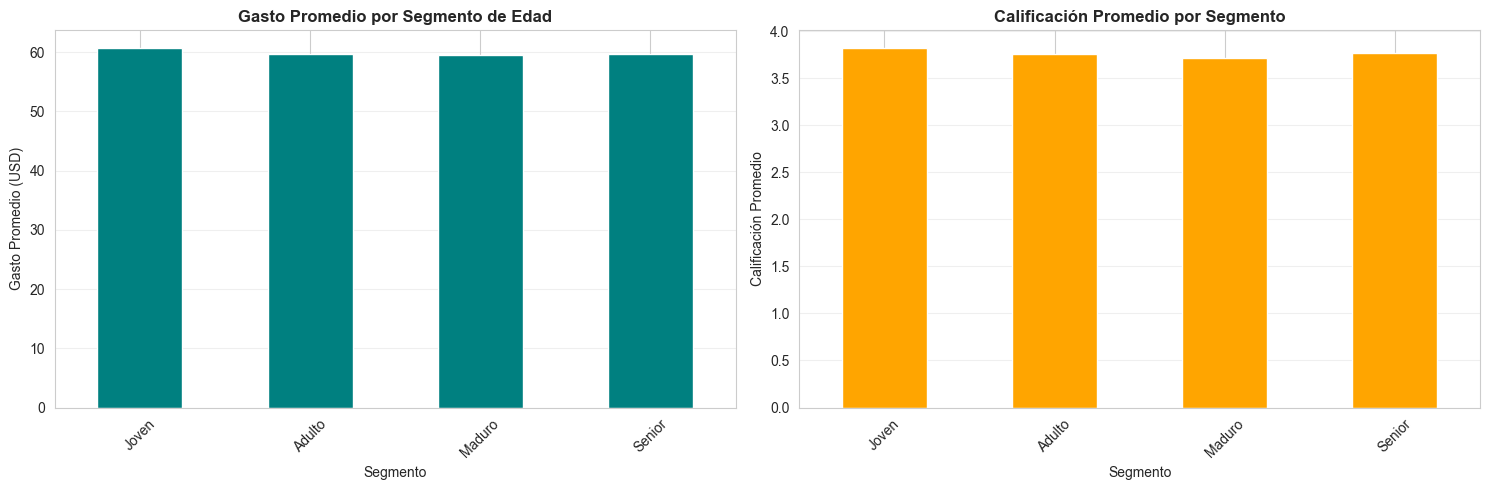

🏆 Top 15 Productos Más Comprados:


Item Purchased
Blouse        171
Jewelry       171
Pants         171
Shirt         169
Dress         166
Sweater       164
Jacket        163
Belt          161
Sunglasses    161
Coat          161
Sandals       160
Socks         159
Skirt         158
Shorts        157
Scarf         157
Name: count, dtype: int64

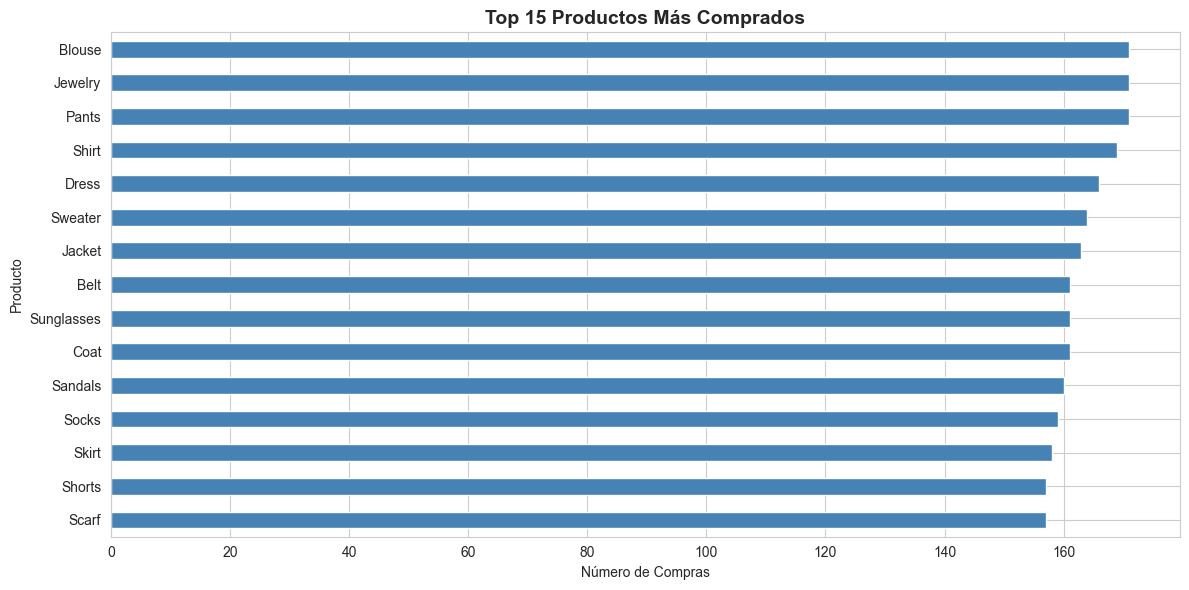

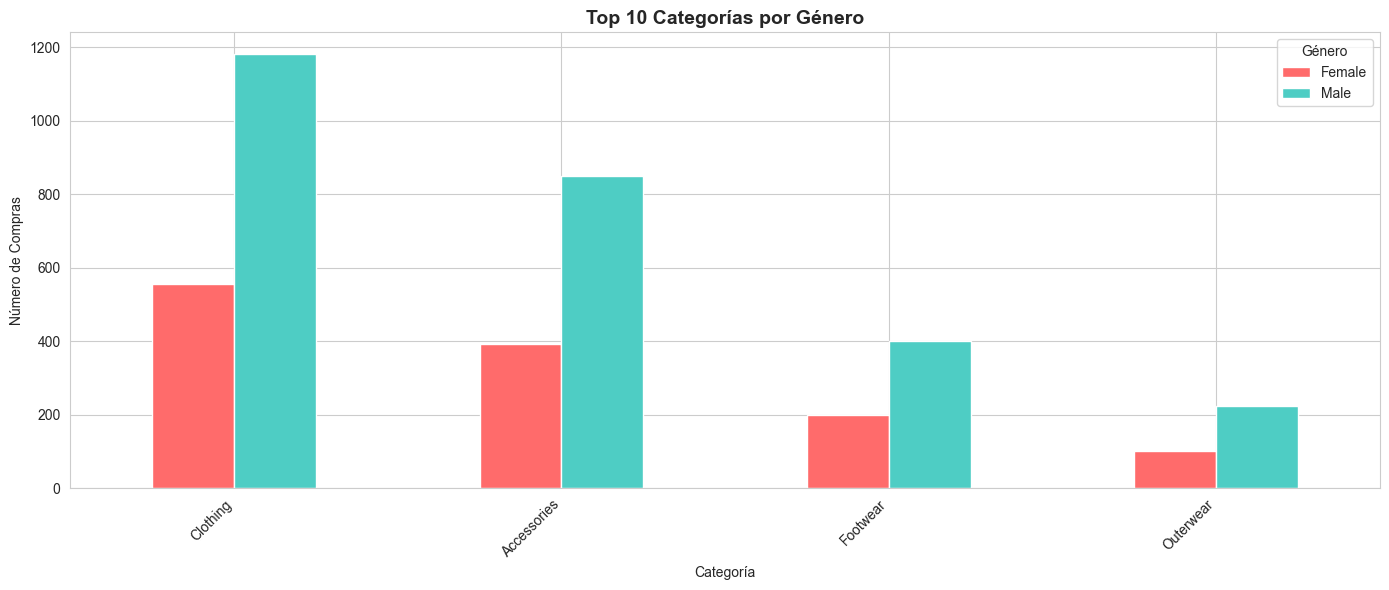

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Distribución de Variables Categóricas', fontsize=16, fontweight='bold')

# Género
df['Gender'].value_counts().plot(kind='bar', ax=axes[0,0], color=['#FF6B6B', '#4ECDC4'])
axes[0,0].set_title('Distribución por Género')
axes[0,0].set_xlabel('Género')
axes[0,0].set_ylabel('Frecuencia')
axes[0,0].tick_params(axis='x', rotation=45)

# Categoría de productos
top_categories = df['Category'].value_counts().head(10)
top_categories.plot(kind='barh', ax=axes[0,1], color='skyblue')
axes[0,1].set_title('Top 10 Categorías de Productos')
axes[0,1].set_xlabel('Frecuencia')

# Temporada
df['Season'].value_counts().plot(kind='pie', ax=axes[0,2], autopct='%1.1f%%', 
                                  colors=['#FFD93D', '#6BCB77', '#FF6B6B', '#4D96FF'])
axes[0,2].set_title('Distribución por Temporada')
axes[0,2].set_ylabel('')

# Método de pago
df['Payment Method'].value_counts().plot(kind='bar', ax=axes[1,0], color='coral')
axes[1,0].set_title('Métodos de Pago')
axes[1,0].set_xlabel('Método')
axes[1,0].set_ylabel('Frecuencia')
axes[1,0].tick_params(axis='x', rotation=45)

# Estado de suscripción
df['Subscription Status'].value_counts().plot(kind='bar', ax=axes[1,1], 
                                               color=['#95E1D3', '#F38181'])
axes[1,1].set_title('Estado de Suscripción')
axes[1,1].set_xlabel('Estado')
axes[1,1].set_ylabel('Frecuencia')
axes[1,1].tick_params(axis='x', rotation=45)

# Frecuencia de compras
freq_counts = df['Frequency of Purchases'].value_counts()
freq_counts.plot(kind='bar', ax=axes[1,2], color='lightgreen')
axes[1,2].set_title('Frecuencia de Compras')
axes[1,2].set_xlabel('Frecuencia')
axes[1,2].set_ylabel('Cantidad')
axes[1,2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# %%
# Distribución de Variables Numéricas
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Distribución de Variables Numéricas', fontsize=16, fontweight='bold')

# Edad
axes[0,0].hist(df['Age'], bins=30, color='#6C5CE7', alpha=0.7, edgecolor='black')
axes[0,0].set_title('Distribución de Edad')
axes[0,0].set_xlabel('Edad')
axes[0,0].set_ylabel('Frecuencia')
axes[0,0].axvline(df['Age'].mean(), color='red', linestyle='--', 
                   label=f'Media: {df["Age"].mean():.1f}')
axes[0,0].legend()

# Monto de compra
axes[0,1].hist(df['Purchase Amount (USD)'], bins=30, color='#00B894', alpha=0.7, edgecolor='black')
axes[0,1].set_title('Distribución de Monto de Compra')
axes[0,1].set_xlabel('Monto (USD)')
axes[0,1].set_ylabel('Frecuencia')
axes[0,1].axvline(df['Purchase Amount (USD)'].mean(), color='red', linestyle='--', 
                   label=f'Media: ${df["Purchase Amount (USD)"].mean():.2f}')
axes[0,1].legend()

# Review Rating
axes[1,0].hist(df['Review Rating'], bins=20, color='#FDCB6E', alpha=0.7, edgecolor='black')
axes[1,0].set_title('Distribución de Calificaciones')
axes[1,0].set_xlabel('Calificación')
axes[1,0].set_ylabel('Frecuencia')
axes[1,0].axvline(df['Review Rating'].mean(), color='red', linestyle='--', 
                   label=f'Media: {df["Review Rating"].mean():.2f}')
axes[1,0].legend()

# Compras previas
axes[1,1].hist(df['Previous Purchases'], bins=30, color='#E17055', alpha=0.7, edgecolor='black')
axes[1,1].set_title('Distribución de Compras Previas')
axes[1,1].set_xlabel('Número de Compras Previas')
axes[1,1].set_ylabel('Frecuencia')
axes[1,1].axvline(df['Previous Purchases'].mean(), color='red', linestyle='--', 
                   label=f'Media: {df["Previous Purchases"].mean():.1f}')
axes[1,1].legend()

plt.tight_layout()
plt.show()

# %%
# Matriz de Correlación
print("Matriz de Correlación:")
numeric_cols = ['Age', 'Purchase Amount (USD)', 'Review Rating', 'Previous Purchases']
correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, fmt='.3f')
plt.title('Matriz de Correlación de Variables Numéricas', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# %%
# Análisis por Segmentos de Edad
print("Análisis por Segmento de Edad:")
segment_analysis = df.groupby('Customer_Segment').agg({
    'Purchase Amount (USD)': ['mean', 'sum', 'count'],
    'Review Rating': 'mean',
    'Previous Purchases': 'mean'
}).round(2)
display(segment_analysis)

# %%
# Visualización de segmentos
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

segment_spending = df.groupby('Customer_Segment')['Purchase Amount (USD)'].mean()
segment_spending.plot(kind='bar', ax=axes[0], color='teal')
axes[0].set_title('Gasto Promedio por Segmento de Edad', fontweight='bold')
axes[0].set_xlabel('Segmento')
axes[0].set_ylabel('Gasto Promedio (USD)')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

segment_rating = df.groupby('Customer_Segment')['Review Rating'].mean()
segment_rating.plot(kind='bar', ax=axes[1], color='orange')
axes[1].set_title('Calificación Promedio por Segmento', fontweight='bold')
axes[1].set_xlabel('Segmento')
axes[1].set_ylabel('Calificación Promedio')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# %%
# Top Productos Más Comprados
print("Top 15 Productos Más Comprados:")
top_items = df['Item Purchased'].value_counts().head(15)
display(top_items)

plt.figure(figsize=(12, 6))
top_items.plot(kind='barh', color='steelblue')
plt.title('Top 15 Productos Más Comprados', fontsize=14, fontweight='bold')
plt.xlabel('Número de Compras')
plt.ylabel('Producto')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# %%
# Análisis de Categorías por Género
category_gender = pd.crosstab(df['Category'], df['Gender'])
top_categories_gender = category_gender.sum(axis=1).nlargest(10)
category_gender_top = category_gender.loc[top_categories_gender.index]

category_gender_top.plot(kind='bar', figsize=(14, 6), color=['#FF6B6B', '#4ECDC4'])
plt.title('Top 10 Categorías por Género', fontsize=14, fontweight='bold')
plt.xlabel('Categoría')
plt.ylabel('Número de Compras')
plt.legend(title='Género')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
print("Creando matriz de interacciones usuario-producto...")

# Calcular puntuación de interacción basada en múltiples factores
df['interaction_score'] = (
    df['Review Rating'] * 0.4 +  # 40% peso a la calificación
    (df['Purchase Amount (USD)'] / df['Purchase Amount (USD)'].max()) * 5 * 0.3 +  # 30% al monto
    (df['Previous Purchases'] / df['Previous Purchases'].max()) * 5 * 0.3  # 30% a lealtad
)

print(f"  Puntuación de interacción creada")
print(f"  - Rango: {df['interaction_score'].min():.2f} - {df['interaction_score'].max():.2f}")
print(f"  - Media: {df['interaction_score'].mean():.2f}")

# %%
# Crear matriz pivote usuario-producto
user_item_matrix = df.pivot_table(
    index='Customer ID',
    columns='Item Purchased',
    values='interaction_score',
    aggfunc='mean'
).fillna(0)

print(f"Matriz usuario-producto creada:")
print(f"  - Usuarios: {user_item_matrix.shape[0]:,}")
print(f"  - Productos: {user_item_matrix.shape[1]:,}")
print(f"  - Sparsity: {(1 - (user_item_matrix > 0).sum().sum() / (user_item_matrix.shape[0] * user_item_matrix.shape[1])) * 100:.2f}%")

# %%
# Encoding de variables categóricas
le_category = LabelEncoder()
le_gender = LabelEncoder()

df['Category_Encoded'] = le_category.fit_transform(df['Category'])
df['Gender_Encoded'] = le_gender.fit_transform(df['Gender'])

print("Variables categóricas codificadas")

🔧 Creando matriz de interacciones usuario-producto...
  ✓ Puntuación de interacción creada
  - Rango: 1.46 - 4.90
  - Media: 3.16
✓ Matriz usuario-producto creada:
  - Usuarios: 3,900
  - Productos: 25
  - Sparsity: 96.00%
✓ Variables categóricas codificadas


In [ ]:
print("Modelo 1: Filtrado Colaborativo Basado en Ítems")

# Calcular similitud entre productos usando cosine similarity
item_similarity = cosine_similarity(user_item_matrix.T)
item_similarity_df = pd.DataFrame(
    item_similarity,
    index=user_item_matrix.columns,
    columns=user_item_matrix.columns
)

print(f"Matriz de similitud calculada: {item_similarity_df.shape}")
print(f"  - Similitud promedio: {item_similarity_df.values[np.triu_indices_from(item_similarity_df.values, k=1)].mean():.3f}")

# %%
# Función para obtener recomendaciones basadas en ítems
def get_item_based_recommendations(item_name, top_n=5):
    """
    Obtiene recomendaciones basadas en similitud de ítems
    
    Args:
        item_name: Nombre del producto
        top_n: Número de recomendaciones a retornar
    
    Returns:
        Lista de tuplas (producto, score de similitud)
    """
    if item_name not in item_similarity_df.index:
        return []
    
    similar_items = item_similarity_df[item_name].sort_values(ascending=False)[1:top_n+1]
    return list(zip(similar_items.index, similar_items.values))

# Ejemplo de recomendaciones
sample_item = user_item_matrix.columns[0]
recommendations = get_item_based_recommendations(sample_item, top_n=5)

print(f"\nEjemplo: Recomendaciones para '{sample_item}':")
for i, (item, score) in enumerate(recommendations, 1):
    print(f"  {i}. {item} (similitud: {score:.3f})")

# %% [markdown]
# ### 6.2 SVD (Matrix Factorization)

# %%
print("Modelo 2: SVD (Matrix Factorization)")

# Preparar datos para Surprise
reader = Reader(rating_scale=(df['interaction_score'].min(), df['interaction_score'].max()))
data = Dataset.load_from_df(df[['Customer ID', 'Item Purchased', 'interaction_score']], reader)

# Split train-test
trainset = data.build_full_trainset()
testset = trainset.build_anti_testset()

# Entrenar modelo SVD
svd_model = SVD(n_factors=50, n_epochs=20, lr_all=0.005, reg_all=0.02, random_state=42)
svd_model.fit(trainset)

print("Modelo SVD entrenado")
print(f"  - Factores latentes: 50")
print(f"  - Épocas: 20")

# %%
# Evaluación del modelo
print("Evaluando modelo con validación cruzada...")
cv_results = cross_validate(svd_model, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

rmse_mean = cv_results['test_rmse'].mean()
rmse_std = cv_results['test_rmse'].std()
mae_mean = cv_results['test_mae'].mean()
mae_std = cv_results['test_mae'].std()

print(f"  RMSE: {rmse_mean:.4f} (±{rmse_std:.4f})")
print(f"  MAE:  {mae_mean:.4f} (±{mae_std:.4f})")

# %%
# Función para obtener recomendaciones con SVD
def get_svd_recommendations(customer_id, top_n=5):
    """
    Obtiene recomendaciones usando SVD
    
    Args:
        customer_id: ID del cliente
        top_n: Número de recomendaciones a retornar
    
    Returns:
        Lista de tuplas (producto, score predicho)
    """
    # Obtener todos los items
    all_items = df['Item Purchased'].unique()
    
    # Obtener items ya comprados por el cliente
    customer_items = set(df[df['Customer ID'] == customer_id]['Item Purchased'])
    
    # Predecir scores para items no comprados
    predictions_list = []
    
    for item in all_items:
        if item not in customer_items:
            pred = svd_model.predict(customer_id, item)
            predictions_list.append((item, pred.est))
    
    # Ordenar y retornar top N
    predictions_list.sort(key=lambda x: x[1], reverse=True)
    return predictions_list[:top_n]

# Ejemplo de recomendaciones SVD
sample_customer = df['Customer ID'].iloc[0]
svd_recs = get_svd_recommendations(sample_customer, top_n=5)

print(f"\nEjemplo: Recomendaciones SVD para Cliente {sample_customer}:")
for i, (item, score) in enumerate(svd_recs, 1):
    print(f"  {i}. {item} (score: {score:.3f})")

# %% [markdown]
# ### 6.3 Sistema Híbrido (Colaborativo + Contenido)

# %%
print("Modelo 3: Sistema Híbrido")

# Crear perfiles de usuario
user_profiles = df.groupby('Customer ID').agg({
    'Category_Encoded': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0],
    'Purchase Amount (USD)': 'mean',
    'Review Rating': 'mean',
    'Age': 'first',
    'Gender_Encoded': 'first'
}).reset_index()

# Crear perfiles de items
item_profiles = df.groupby('Item Purchased').agg({
    'Category_Encoded': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0],
    'Purchase Amount (USD)': 'mean',
    'Review Rating': 'mean'
}).reset_index()

print(f"Perfiles creados:")
print(f"  - Perfiles de usuario: {len(user_profiles)}")
print(f"  - Perfiles de producto: {len(item_profiles)}")

# %%
def get_hybrid_recommendations(customer_id, top_n=5, alpha=0.6):
    """
    Sistema híbrido: combina filtrado colaborativo y basado en contenido
    
    Args:
        customer_id: ID del cliente
        top_n: Número de recomendaciones
        alpha: Peso para el score colaborativo (1-alpha para contenido)
    
    Returns:
        Lista de tuplas (producto, score híbrido)
    """
    # Recomendaciones colaborativas (SVD)
    collab_recs = get_svd_recommendations(customer_id, top_n=top_n*2)
    
    # Verificar si el usuario existe en los perfiles
    if customer_id not in user_profiles['Customer ID'].values:
        return collab_recs[:top_n]
    
    user_profile = user_profiles[user_profiles['Customer ID'] == customer_id].iloc[0]
    
    # Calcular score híbrido
    hybrid_scores = []
    for item, collab_score in collab_recs:
        if item in item_profiles['Item Purchased'].values:
            item_profile = item_profiles[item_profiles['Item Purchased'] == item].iloc[0]
            
            # Score basado en contenido (similitud de categoría)
            content_score = 5.0 if item_profile['Category_Encoded'] == user_profile['Category_Encoded'] else 2.5
            
            # Combinar scores
            hybrid_score = alpha * collab_score + (1 - alpha) * content_score
            hybrid_scores.append((item, hybrid_score, collab_score, content_score))
    
    # Ordenar y retornar
    hybrid_scores.sort(key=lambda x: x[1], reverse=True)
    return [(item, score) for item, score, _, _ in hybrid_scores[:top_n]]

# Ejemplo de recomendaciones híbridas
hybrid_recs = get_hybrid_recommendations(sample_customer, top_n=5, alpha=0.6)

print(f"\nEjemplo: Recomendaciones Híbridas para Cliente {sample_customer}:")
for i, (item, score) in enumerate(hybrid_recs, 1):
    category = df[df['Item Purchased'] == item]['Category'].iloc[0]
    print(f"  {i}. {item}")
    print(f"     Categoría: {category} | Score: {score:.3f}")

🤖 Modelo 1: Filtrado Colaborativo Basado en Ítems
✓ Matriz de similitud calculada: (25, 25)
  - Similitud promedio: 0.000

📦 Ejemplo: Recomendaciones para 'Backpack':
  1. Pants (similitud: 0.000)
  2. Sweater (similitud: 0.000)
  3. Sunglasses (similitud: 0.000)
  4. Socks (similitud: 0.000)
  5. Sneakers (similitud: 0.000)
🤖 Modelo 2: SVD (Matrix Factorization)
✓ Modelo SVD entrenado
  - Factores latentes: 50
  - Épocas: 20
📊 Evaluando modelo con validación cruzada...
  RMSE: 0.6389 (±0.0098)
  MAE:  0.5194 (±0.0097)

👤 Ejemplo: Recomendaciones SVD para Cliente 1:
  1. Dress (score: 3.213)
  2. Gloves (score: 3.190)
  3. Shirt (score: 3.174)
  4. Coat (score: 3.150)
  5. Belt (score: 3.145)
🤖 Modelo 3: Sistema Híbrido
✓ Perfiles creados:
  - Perfiles de usuario: 3900
  - Perfiles de producto: 25

🔀 Ejemplo: Recomendaciones Híbridas para Cliente 1:
  1. Dress
     Categoría: Clothing | Score: 3.928
  2. Shirt
     Categoría: Clothing | Score: 3.904
  3. Skirt
     Categoría: Clothing 

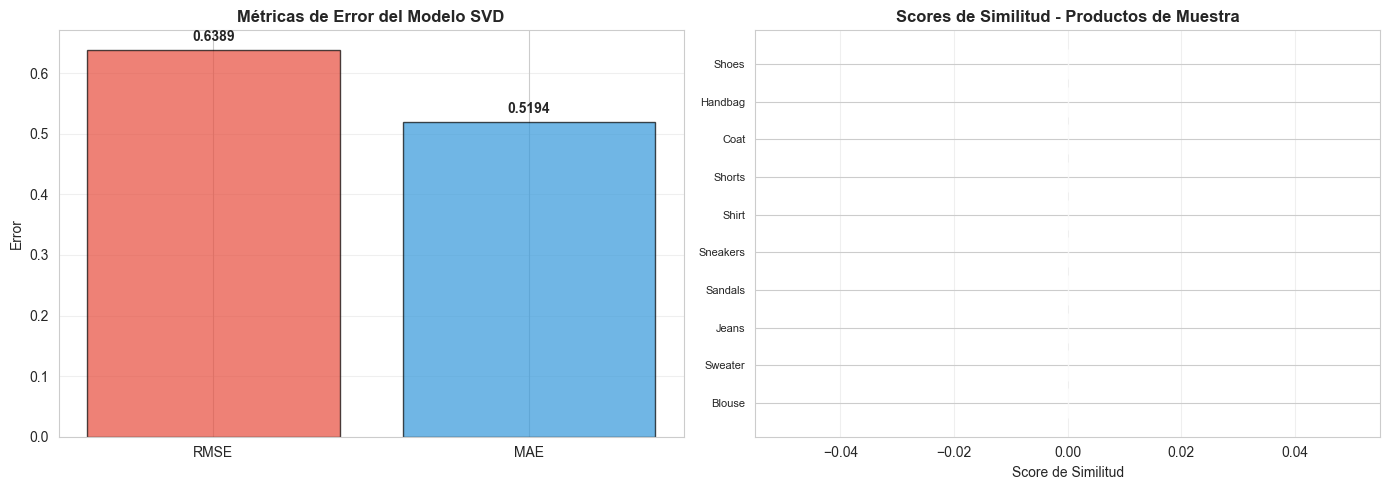

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Métricas de error
axes[0].bar(['RMSE', 'MAE'], [rmse_mean, mae_mean], 
            color=['#E74C3C', '#3498DB'], alpha=0.7, edgecolor='black')
axes[0].set_title('Métricas de Error del Modelo SVD', fontweight='bold')
axes[0].set_ylabel('Error')
axes[0].grid(axis='y', alpha=0.3)

# Agregar valores en las barras
for i, v in enumerate([rmse_mean, mae_mean]):
    axes[0].text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

# Comparación de scores de diferentes modelos
sample_items_comparison = df['Item Purchased'].unique()[:10]
item_scores = []
for item in sample_items_comparison:
    item_recs = get_item_based_recommendations(item, top_n=1)
    if item_recs:
        item_scores.append(item_recs[0][1])
    else:
        item_scores.append(0)

axes[1].barh(range(len(sample_items_comparison)), item_scores, color='#9B59B6', alpha=0.7)
axes[1].set_yticks(range(len(sample_items_comparison)))
axes[1].set_yticklabels([item[:30] + '...' if len(item) > 30 else item 
                          for item in sample_items_comparison], fontsize=8)
axes[1].set_title('Scores de Similitud - Productos de Muestra', fontweight='bold')
axes[1].set_xlabel('Score de Similitud')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
def recommendation_interface():
    """
    Interfaz interactiva para obtener recomendaciones del sistema
    """
    print("\n" + "="*70)
    print("SISTEMA DE RECOMENDACIÓN DE PRODUCTOS E-COMMERCE")
    print("="*70)
    
    print("\nOpciones disponibles:")
    print("1. Recomendaciones personalizadas para un cliente")
    print("2. Productos similares a un artículo específico")
    print("3. Estadísticas y perfil del cliente")
    print("4. Top productos por categoría")
    
    choice = input("\nSelecciona una opción (1-4): ")
    
    if choice == '1':
        # Recomendaciones para cliente
        print("\n" + "-"*70)
        customer_id = input("Ingresa el ID del cliente: ")
        try:
            customer_id = int(customer_id)
            if customer_id not in df['Customer ID'].values:
                print(f"Cliente {customer_id} no encontrado en la base de datos")
                return
            
            print(f"\nGenerando recomendaciones para Cliente {customer_id}...")
            
            # Información del cliente
            customer_data = df[df['Customer ID'] == customer_id]
            print(f"\nPerfil del Cliente:")
            print(f"  • Edad: {customer_data['Age'].iloc[0]} años")
            print(f"  • Género: {customer_data['Gender'].iloc[0]}")
            print(f"  • Total gastado: ${customer_data['Purchase Amount (USD)'].sum():.2f}")
            print(f"  • Número de compras: {len(customer_data)}")
            
            # Historial de compras
            customer_history = customer_data['Item Purchased'].unique()
            print(f"\nHistorial de compras ({len(customer_history)} productos):")
            for i, item in enumerate(customer_history[:5], 1):
                category = customer_data[customer_data['Item Purchased'] == item]['Category'].iloc[0]
                print(f"  {i}. {item} ({category})")
            if len(customer_history) > 5:
                print(f"  ... y {len(customer_history) - 5} más")
            
            # Recomendaciones híbridas
            recommendations = get_hybrid_recommendations(customer_id, top_n=10)
            print(f"\nTop 10 Recomendaciones Personalizadas:")
            print("-"*70)
            for i, (item, score) in enumerate(recommendations, 1):
                category = df[df['Item Purchased'] == item]['Category'].iloc[0]
                avg_price = df[df['Item Purchased'] == item]['Purchase Amount (USD)'].mean()
                avg_rating = df[df['Item Purchased'] == item]['Review Rating'].mean()
                print(f"  {i:2d}. {item}")
                print(f"      Categoría: {category}")
                print(f"      Precio promedio: ${avg_price:.2f}")
                print(f"      Rating: {avg_rating:.2f}/5")
                print(f"      Score: {score:.3f}")
                print()
                
        except ValueError:
            print("ID de cliente inválido. Debe ser un número.")
    
    elif choice == '2':
        # Productos similares
        print("\n" + "-"*70)
        print("Productos disponibles (muestra aleatoria):")
        sample_items = np.random.choice(df['Item Purchased'].unique(), 
                                       size=min(15, len(df['Item Purchased'].unique())),
                                       replace=False)
        for i, item in enumerate(sample_items, 1):
            print(f"  {i}. {item}")
        
        item_name = input("\nIngresa el nombre exacto del producto: ")
        
        if item_name in df['Item Purchased'].values:
            print(f"\nProducto: {item_name}")
            
            # Información del producto
            product_data = df[df['Item Purchased'] == item_name]
            category = product_data['Category'].iloc[0]
            avg_price = product_data['Purchase Amount (USD)'].mean()
            avg_rating = product_data['Review Rating'].mean()
            purchase_count = len(product_data)
            
            print(f"  Categoría: {category}")
            print(f"  Precio promedio: ${avg_price:.2f}")
            print(f"  Rating promedio: {avg_rating:.2f}/5")
            print(f"  Veces comprado: {purchase_count}")
            
            # Recomendaciones similares
            recommendations = get_item_based_recommendations(item_name, top_n=10)
            print(f"\nProductos similares (Top 10):")
            print("-"*70)
            for i, (item, score) in enumerate(recommendations, 1):
                item_category = df[df['Item Purchased'] == item]['Category'].iloc[0]
                item_price = df[df['Item Purchased'] == item]['Purchase Amount (USD)'].mean()
                item_rating = df[df['Item Purchased'] == item]['Review Rating'].mean()
                print(f"  {i:2d}. {item}")
                print(f"      Categoría: {item_category}")
                print(f"      Precio: ${item_price:.2f}")
                print(f"      Rating: {item_rating:.2f}/5")
                print(f"      Similitud: {score:.3f}")
                print()
        else:
            print(f"Producto '{item_name}' no encontrado")
            print("\nSugerencia: Copia y pega exactamente el nombre de la lista anterior")
    
    elif choice == '3':
        # Estadísticas del cliente
        print("\n" + "-"*70)
        customer_id = input("Ingresa el ID del cliente: ")
        try:
            customer_id = int(customer_id)
            if customer_id not in df['Customer ID'].values:
                print(f"Cliente {customer_id} no encontrado")
                return
            
            customer_data = df[df['Customer ID'] == customer_id]
            
            print(f"\nPERFIL COMPLETO DEL CLIENTE {customer_id}")
            print("="*70)
            
            # Información demográfica
            print("\nInformación Demográfica:")
            print(f"  • Edad: {customer_data['Age'].iloc[0]} años")
            print(f"  • Género: {customer_data['Gender'].iloc[0]}")
            print(f"  • Segmento: {customer_data['Customer_Segment'].iloc[0]}")
            print(f"  • Ubicación: {customer_data['Location'].iloc[0]}")
            
            # Comportamiento de compra
            print("\nComportamiento de Compra:")
            print(f"  • Total de transacciones: {len(customer_data)}")
            print(f"  • Productos únicos comprados: {customer_data['Item Purchased'].nunique()}")
            print(f"  • Gasto total: ${customer_data['Purchase Amount (USD)'].sum():.2f}")
            print(f"  • Gasto promedio: ${customer_data['Purchase Amount (USD)'].mean():.2f}")
            print(f"  • Gasto mínimo: ${customer_data['Purchase Amount (USD)'].min():.2f}")
            print(f"  • Gasto máximo: ${customer_data['Purchase Amount (USD)'].max():.2f}")
            
            # Preferencias
            print("\nPreferencias y Satisfacción:")
            print(f"  • Calificación promedio: {customer_data['Review Rating'].mean():.2f}/5")
            print(f"  • Categoría favorita: {customer_data['Category'].mode()[0]}")
            print(f"  • Color preferido: {customer_data['Color'].mode()[0]}")
            print(f"  • Temporada de mayor compra: {customer_data['Season'].mode()[0]}")
            
            # Lealtad
            print("\nIndicadores de Lealtad:")
            print(f"  • Estado de suscripción: {customer_data['Subscription Status'].iloc[0]}")
            print(f"  • Frecuencia de compra: {customer_data['Frequency of Purchases'].iloc[0]}")
            print(f"  • Compras previas: {customer_data['Previous Purchases'].mean():.0f}")
            print(f"  • Método de pago preferido: {customer_data['Payment Method'].mode()[0]}")
            print(f"  • Uso de descuentos: {'Sí' if customer_data['Discount Applied'].mode()[0] == 'Yes' else 'No'}")
            
            # Top categorías
            print("\nTop 5 Categorías Compradas:")
            top_categories = customer_data['Category'].value_counts().head(5)
            for i, (cat, count) in enumerate(top_categories.items(), 1):
                print(f"  {i}. {cat}: {count} compras")
            
        except ValueError:
            print("ID de cliente inválido")
    
    elif choice == '4':
        # Top productos por categoría
        print("\n" + "-"*70)
        print("Categorías disponibles:")
        categories = sorted(df['Category'].unique())
        for i, cat in enumerate(categories, 1):
            print(f"  {i}. {cat}")
        
        category = input("\nIngresa el nombre de la categoría: ")
        
        if category in df['Category'].values:
            category_data = df[df['Category'] == category]
            
            print(f"\nCategoría: {category}")
            print(f"  • Total de transacciones: {len(category_data)}")
            print(f"  • Productos únicos: {category_data['Item Purchased'].nunique()}")
            print(f"  • Gasto promedio: ${category_data['Purchase Amount (USD)'].mean():.2f}")
            print(f"  • Rating promedio: {category_data['Review Rating'].mean():.2f}/5")
            
            # Top productos
            top_products = category_data['Item Purchased'].value_counts().head(10)
            print(f"\nTop 10 Productos en {category}:")
            print("-"*70)
            for i, (product, count) in enumerate(top_products.items(), 1):
                product_data = category_data[category_data['Item Purchased'] == product]
                avg_price = product_data['Purchase Amount (USD)'].mean()
                avg_rating = product_data['Review Rating'].mean()
                print(f"  {i:2d}. {product}")
                print(f"      Compras: {count}")
                print(f"      Precio: ${avg_price:.2f}")
                print(f"      Rating: {avg_rating:.2f}/5")
                print()
        else:
            print(f"Categoría '{category}' no encontrada")
    
    else:
        print("Opción no válida")

print("\nPara usar el sistema de recomendación, ejecuta:")
print("   recommendation_interface()")


💡 Para usar el sistema de recomendación, ejecuta:
   recommendation_interface()


📊 Análisis RFM (Recency, Frequency, Monetary)
----------------------------------------------------------------------

Distribución de Segmentos RFM:


Segment
Loyal Customers        1161
Lost                    902
Potential Loyalists     600
At Risk                 596
Hibernating             373
Champions               268
Name: count, dtype: int64

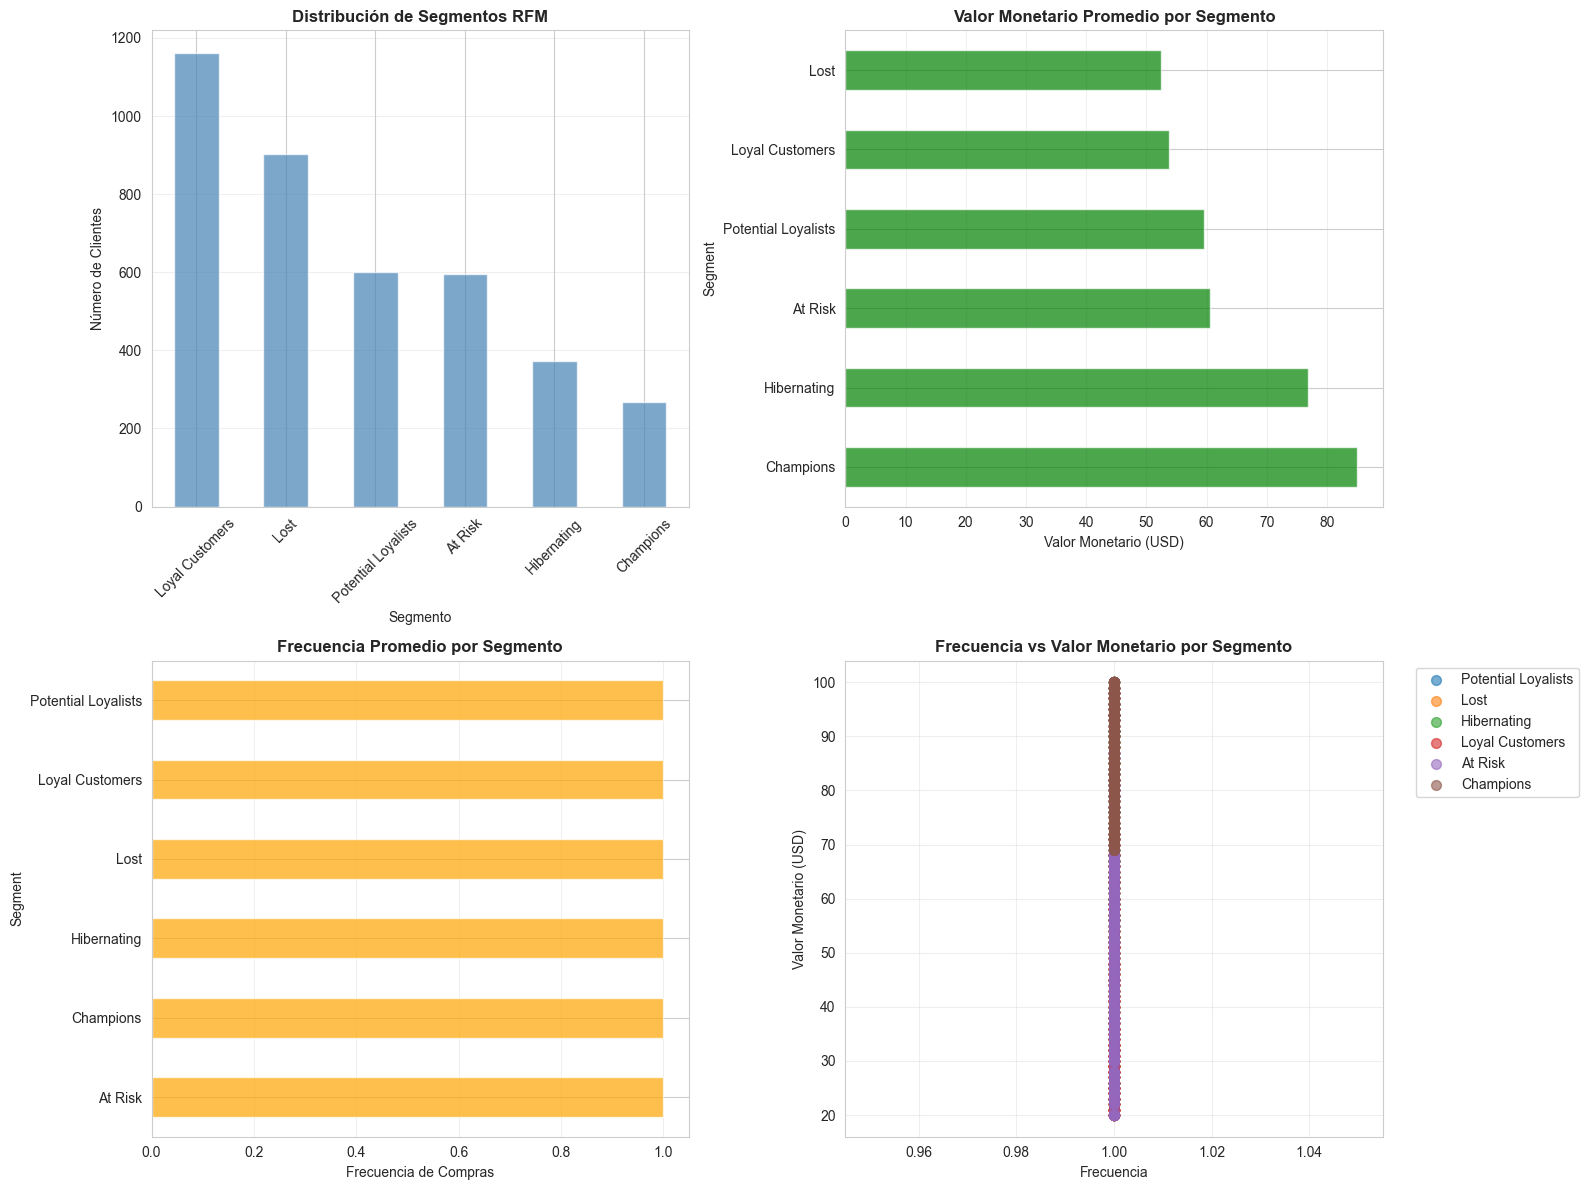

In [ ]:
print("Análisis RFM (Recency, Frequency, Monetary)")
print("-"*70)

# Calcular métricas RFM por cliente
rfm = df.groupby('Customer ID').agg({
    'Purchase Amount (USD)': 'sum',  # Monetary
    'Item Purchased': 'count'  # Frequency
}).reset_index()

rfm.columns = ['Customer ID', 'Monetary', 'Frequency']

# Como no tenemos fechas, usamos Previous Purchases como proxy de Recency
recency_proxy = df.groupby('Customer ID')['Previous Purchases'].mean().reset_index()
recency_proxy.columns = ['Customer ID', 'Recency']
rfm = rfm.merge(recency_proxy, on='Customer ID')

# Crear scores RFM (1-5)
rfm['R_Score'] = pd.qcut(rfm['Recency'], q=5, labels=[5, 4, 3, 2, 1], duplicates='drop')
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5], duplicates='drop')
rfm['M_Score'] = pd.qcut(rfm['Monetary'], q=5, labels=[1, 2, 3, 4, 5], duplicates='drop')

# Score total
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

# Segmentación
def rfm_segment(row):
    if row['R_Score'] >= 4 and row['F_Score'] >= 4 and row['M_Score'] >= 4:
        return 'Champions'
    elif row['R_Score'] >= 3 and row['F_Score'] >= 3:
        return 'Loyal Customers'
    elif row['R_Score'] >= 4 and row['F_Score'] < 3:
        return 'Potential Loyalists'
    elif row['R_Score'] < 3 and row['F_Score'] >= 4:
        return 'At Risk'
    elif row['R_Score'] < 3 and row['F_Score'] < 3 and row['M_Score'] >= 3:
        return 'Hibernating'
    else:
        return 'Lost'

rfm['Segment'] = rfm.apply(rfm_segment, axis=1)

print("\nDistribución de Segmentos RFM:")
segment_dist = rfm['Segment'].value_counts()
display(segment_dist)

# %%
# Visualización de segmentos RFM
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Distribución de segmentos
segment_dist.plot(kind='bar', ax=axes[0,0], color='steelblue', alpha=0.7)
axes[0,0].set_title('Distribución de Segmentos RFM', fontweight='bold')
axes[0,0].set_xlabel('Segmento')
axes[0,0].set_ylabel('Número de Clientes')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(axis='y', alpha=0.3)

# Valor monetario por segmento
segment_monetary = rfm.groupby('Segment')['Monetary'].mean().sort_values(ascending=False)
segment_monetary.plot(kind='barh', ax=axes[0,1], color='green', alpha=0.7)
axes[0,1].set_title('Valor Monetario Promedio por Segmento', fontweight='bold')
axes[0,1].set_xlabel('Valor Monetario (USD)')
axes[0,1].grid(axis='x', alpha=0.3)

# Frecuencia por segmento
segment_freq = rfm.groupby('Segment')['Frequency'].mean().sort_values(ascending=False)
segment_freq.plot(kind='barh', ax=axes[1,0], color='orange', alpha=0.7)
axes[1,0].set_title('Frecuencia Promedio por Segmento', fontweight='bold')
axes[1,0].set_xlabel('Frecuencia de Compras')
axes[1,0].grid(axis='x', alpha=0.3)

# Scatter plot: Frecuencia vs Monetario por segmento
for segment in rfm['Segment'].unique():
    segment_data = rfm[rfm['Segment'] == segment]
    axes[1,1].scatter(segment_data['Frequency'], segment_data['Monetary'], 
                     label=segment, alpha=0.6, s=50)

axes[1,1].set_title('Frecuencia vs Valor Monetario por Segmento', fontweight='bold')
axes[1,1].set_xlabel('Frecuencia')
axes[1,1].set_ylabel('Valor Monetario (USD)')
axes[1,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1,1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
print("Guardando resultados y modelos...")

# Crear directorio para resultados si no existe
import os
if not os.path.exists('resultados'):
    os.makedirs('resultados')

# 1. Guardar matriz de similitud
item_similarity_df.to_csv('resultados/item_similarity_matrix.csv')
print("  Matriz de similitud guardada")

# 2. Guardar análisis RFM
rfm.to_csv('resultados/rfm_analysis.csv', index=False)
print("  Análisis RFM guardado")

# 3. Guardar estadísticas generales
with open('resultados/estadisticas_generales.txt', 'w', encoding='utf-8') as f:
    f.write("ESTADÍSTICAS GENERALES DEL DATASET\n")
    f.write("="*70 + "\n\n")
    f.write(f"Total de registros: {len(df):,}\n")
    f.write(f"Clientes únicos: {df['Customer ID'].nunique():,}\n")
    f.write(f"Productos únicos: {df['Item Purchased'].nunique():,}\n")
    f.write(f"Categorías: {df['Category'].nunique()}\n\n")
    f.write(f"Gasto promedio: ${df['Purchase Amount (USD)'].mean():.2f}\n")
    f.write(f"Gasto total: ${df['Purchase Amount (USD)'].sum():,.2f}\n")
    f.write(f"Calificación promedio: {df['Review Rating'].mean():.2f}/5\n\n")
    f.write(f"Categoría más popular: {df['Category'].mode()[0]}\n")
    f.write(f"Producto más vendido: {df['Item Purchased'].mode()[0]}\n")

print("  Estadísticas generales guardadas")

# 4. Guardar recomendaciones de muestra
sample_recommendations = []
for customer_id in df['Customer ID'].unique()[:20]:
    recs = get_hybrid_recommendations(customer_id, top_n=5)
    for rank, (item, score) in enumerate(recs, 1):
        sample_recommendations.append({
            'Customer ID': customer_id,
            'Rank': rank,
            'Recommended Item': item,
            'Score': score
        })

sample_recs_df = pd.DataFrame(sample_recommendations)
sample_recs_df.to_csv('resultados/sample_recommendations.csv', index=False)
print("  Recomendaciones de muestra guardadas")

# 5. Guardar modelo SVD
import pickle
with open('resultados/svd_model.pkl', 'wb') as f:
    pickle.dump(svd_model, f)
print("  Modelo SVD guardado")

print("\nTodos los resultados han sido guardados en la carpeta 'resultados/'")

💾 Guardando resultados y modelos...
  ✓ Matriz de similitud guardada
  ✓ Análisis RFM guardado
  ✓ Estadísticas generales guardadas
  ✓ Recomendaciones de muestra guardadas
  ✓ Modelo SVD guardado

✅ Todos los resultados han sido guardados en la carpeta 'resultados/'
